# Homework 3: The Content of Galaxies

## Q1:
These unit tests are provided in `tests/test_matrix.py`. To run, enter the `tests/` directory and run python on the script.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib.pyplot import *

import astropy.units as un
from astropy import constants as const

import sys
sys.path.append("../HW2/")
from matrix import Matrix, make_matrix
from coefficients_reader import read_coefficients

In [2]:
# Nice matplotlib rendering
from matplotlib import rc

rc('text',usetex=True)
rc('font',**{'family':'serif','serif':['Times New Roman'],'size':14})#,'weight':'bold'})
rc('xtick',**{'labelsize':16})
rc('ytick',**{'labelsize':16})
rc('axes',**{'labelsize':18,'titlesize':18})

## Q2:
For a total number density of $N$ = 1 cm$^{-3}$ for convenience, calculate the different number densities as a function of temperature $T$. Make a plot showing the different number densities vary as a function of $T$.

First, we will define our various relations and functions. Note that each one calls the indices $l$ and $u$ in that order always to avoid confusion.

In [3]:
def calc_g_n(n):
    """ Calculate degeneracy factor for Hydrogen """
    return 2*n**2

def calc_transition_freq(l, u):
    """ Transition frequency, above could be in either order """
    E_l = -13.6*un.eV/l**2
    E_u = -13.6*un.eV/u**2
    dE = abs(E_u - E_l)
    return (dE/const.h).to(un.Hz)


def calc_B_ul(Adict, l, u):
    """ Given A_ul dictionary, we can calculate B_ul """
    A_ul = Adict[(l, u)]
    
    nu = calc_transition_freq(l, u)
    
    return (A_ul*const.c**2/(2*const.h * nu**3)).decompose()

def calc_B_lu(Adict, l, u):
    """ Given A_ul dictionary, we can calculate B_lu """
    B_ul = calc_B_ul(Adict, l, u)
    g_l = calc_g_n(l)
    g_u = calc_g_n(u)
    
    return (B_ul*g_u/g_l).decompose()

def calc_J(nu, T):
    return ((2*const.h*nu**3/const.c**2)/(np.exp((const.h*nu)/(const.k_B*T))-1)).decompose()

Load data:

In [4]:
Adict = read_coefficients()

Let's test some of our functions to make sure they have the right units and such.

In [5]:
print(Adict[(1, 5)])
print(calc_B_ul(Adict, 1, 5))
print(calc_B_lu(Adict, 1, 5))
print(calc_transition_freq(1, 5))
J = calc_J(1e14*un.Hz, 300*un.K)
print(J)
print(calc_B_lu(Adict, 1, 5)*J)

4123298.6 1 / s
8888053221.867712 s / kg
222201330546.6928 s / kg
3156926780865238.5 Hz
1.6635138230866307e-15 kg / s2
0.00036963498487266506 1 / s


How do we populate the matrix? Let's look broadly at the terms that go on either side of the equation set. To start, the way I've written it, the left-hand side are terms where we are transitioning _out_ of the level. The right-hand side are terms where we are transitioning in. If we write it as a system of equations **Mx = b**, (using **M** to avoid confusion with $A_{ul}$) where **b = 0**, then we move all of the RHS terms to the LHS with negatives. Or, in summary, we have a system of equations where for each line, we have positive terms describing transitions out of the state and negative terms describing transitions into the state.

Let's say we are in state $i$. What are the terms transitioning out of the state? You can go up or down. Going up via absorption of radiation requires:
\begin{equation}
n_i \left(\sum_{u > i} B_{iu}\right)\bar{J}
\end{equation}
Similarly, we can go down via stimulated emission:
\begin{equation}
n_i \left(\sum_{l < i} B_{il}\right)\bar{J}
\end{equation}
We can also go down via spontaneous emission:
\begin{equation}
n_i \left(\sum_{l < i} A_{il}\right)
\end{equation}
If you look at the first two terms, you'll notice that really, we can combine them as all of the $B$ values that involve an $i$, since there is no $B_{ii}$ term. But since the order to the indices matters, I will keep them separate notationally.

Now let's consider all of the terms going into the state. You can come from a lower state via absorption of radiation:
\begin{equation}
-\left(\sum_{l < i} n_l B_{li}\right)\bar{J}
\end{equation}
Here, we see an advantage to simply keeping all of the terms inside of the summation. Let's do that for coming from an upper state via stimulated emission:
\begin{equation}
-\left(\sum_{u > i} n_u B_{iu} \bar{J}\right)
\end{equation} 
And similarly for spontaneous emission from an upper level to your level:
\begin{equation}
- \left(\sum_{l < i} n_u A_{ui}\right)
\end{equation}

To make our lives simpler, we could say that _every_ matrix element has these six terms. The conditions on the summations mean that there may be no indices that satisfy the condition, and therefore there is no summation, i.e, that term is zero.

However, let's look at the structure of the matrix more closely. As noted by example for the three-level detailed balance matrix, the system of equations that we write down has some properties. We have the current state we are discussing as each row $i$. The positive terms exist all along the diagonals, representing all of the transitions out of state $i$. For the off-diagonals, the columns $j$ represent and transitions _into_ state $i$. The elements below the diagonal represent transitions into the state from a lower one, only possible by absorption. The elements above the diagonal reresent transitions into the state from an upper one, possible by stimulated or spontaneous emission. Since we are dealing directly between states, it means that these will either have one or two terms, respectively. Therefore, given all of these conditions, we could construct the matrix by iterating through each $M_{ij}$ and noting the restrictions.


Let's populate the matrix $M$ as a function with a temperature $T$ in order to calculate the subsequent $\bar{J}$ factors. 

In [6]:
def make_M(T=20000*un.K):
    M = make_matrix(9, 9) #make an empty matrix

    for i in range(1, 10): #row of the element we are considering
        for j in range(1, 10): #column of the element we are considering
            if i == j: #Diagonal term, collect all terms transitioning out of state
                # Absorption from this state to an upper one
                for u in range(i+1, 10):
                    nu = calc_transition_freq(i, u)
                    M[i-1, j-1] += (calc_B_lu(Adict, i, u)*calc_J(nu, T)).value
                # Stimulated emission from this state to a lower one
                for l in range(1, i):
                    nu = calc_transition_freq(l, i)
                    M[i-1, j-1] += (calc_B_ul(Adict, l, i)*calc_J(nu, T)).value
                # Spontaneous emission from this state to a lower one
                for l in range(1, i):
                    A_ul = Adict[(l, i)]
                    M[i-1, j-1] += A_ul.value
            elif i < j: # above the diagonal, so all emission into the state from an upper one.
                A_ul = Adict[(i, j)]
                nu = calc_transition_freq(i, j)
                M[i-1, j-1] += -(A_ul + calc_B_ul(Adict, i, j)*calc_J(nu, T)).value
            elif i > j: #below the diagonal, so all absorption into the state from a lower one.
                nu = calc_transition_freq(j, i)
                M[i-1, j-1] += -(calc_B_lu(Adict, j, i)*calc_J(nu, T)).value   
    return M

Now solve the system **Mx = b = 0**. I, in fact, screwed up when thinking about this. There can be multiple solutions to this, one of which is all of the densities = 0. This is obviously bad. One numberic trick is to input a perturbed value, i.e., the small value below.

In [7]:
M = make_M(20000*un.K)
b = make_matrix(9, 1, value=0.00001)

x = M.solve_linear_system(b)

array = list(map(lambda x: x[0], x.array)) #grab values
array = list(map(lambda x: x/array[0], array)) #divide by first value to get ratios.
array = list(map(lambda x: x/sum(array), array)) #divide by total to get in terms of 1 cm^-3
for i, elem in enumerate(array):
    print("n_%i = %0.5f cm^-3"%(i+1, elem))

n_1 = 0.87700 cm^-3
n_2 = 0.00944 cm^-3
n_3 = 0.00710 cm^-3
n_4 = 0.00860 cm^-3
n_5 = 0.01125 cm^-3
n_6 = 0.01470 cm^-3
n_7 = 0.01888 cm^-3
n_8 = 0.02375 cm^-3
n_9 = 0.02929 cm^-3


Make plots below as a function of temperature



In [8]:
# Make a helper function to do the thing as above
def get_densities(T):
    M = make_M(T)
    b = make_matrix(9, 1, value=0.00001)

    x = M.solve_linear_system(b)
    array = list(map(lambda x: x[0], x.array)) #grab values
    array = list(map(lambda x: x/array[0], array)) #divide by first value to get ratios.
    array = list(map(lambda x: x/sum(array), array)) #divide by total to get in terms of 1 cm^-3
    
    return array

In [9]:
Ts = np.logspace(3, 7, 30)*un.K

data = np.zeros((9, 30)) # 9 densities, 30 temperatures

for i, T in enumerate(Ts):
    data[:, i] = get_densities(T)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


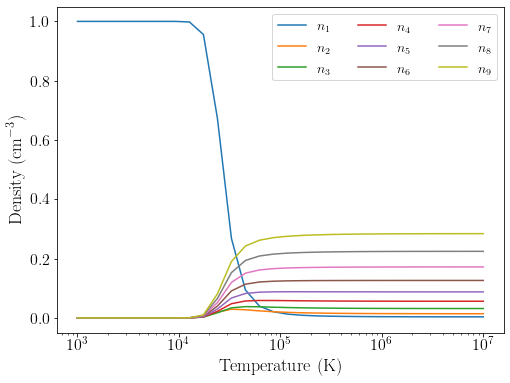

In [10]:
figure(figsize=(8,6))
for i in range(9):
    plot(Ts, data[i, :], label=r"$n_%i$"%(i+1))
xscale('log')
xlabel('Temperature (K)')
ylabel(r'Density (cm$^{-3}$)')
legend(ncol=3)
show()

As one might expect, at low temperatures, there is not enough energy to ionize hydrogen. Given the rule of thumb that $10^4$ K ~ 1 eV (0.86 eV) thermal energy, then we see that right around a few eV, ionization begins to occur, and that by around $10^5$ K, few electrons remain in the ground state, which is to be expected. It takes 10.2 eV to go send an electron from the $n=1$ to $n=2$ state, and not too much more to become fully ionized (13.6 eV ~ $1.6 \times 10^5$ K). Of course, our model has a little flaw in that we do not allow our atoms to ionize, restricting our atoms to be in one of the nine states.